In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel

import hydra
from hydra import compose, initialize
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

import pyrootutils

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.transforms import functional as TF

from probes import *

In [2]:
def setup(model='base_vlm', task='base_vlm_task'):
    '''
    Annoying but necessary function to setup the hydra environment within a jupyter notebook.
    '''
    pyrootutils.setup_root('.', dotenv=True, pythonpath=True)
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(config_path='config')
    cfg = compose(config_name='run', overrides=[f'model={model}', f'task={task}'])
    return cfg

class ImageDataset(Dataset):
    def __init__(self, xs, df, target_feature):
        ys = torch.tensor(df[target_feature].values.astype(int)-1)
        self.ys = F.one_hot(ys, ys.max()+1).to(dtype=torch.float32)
        self.xs = xs
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, i):
        return self.xs[i], self.ys[i]
    
class Probe(torch.nn.Module):
    def __init__(self, pooler, probe_mlp):
        super().__init__()
        self.pooler = pooler
        self.probe = probe_mlp
    def forward(self, x, return_pooled_xs=False):
        xs = self.pooler(x)
        ys = self.probe(xs)
        if return_pooled_xs:
            return ys, xs
        else:
            return ys

# Basic setup for probing the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
batch_size = 512
cfg = setup(task='counting')
task = instantiate(cfg.task)
dataset = ImageDataset(task.dataset_tensor, task.results_df, 'n_objects')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Using device: cuda
Loading task metadata from /scratch/gpfs/ic0523/ACSS-2024/data/counting/metadata.csv...


#### Let's start with CLIP!

In [3]:
def compute_embeddings(model, processor, dataloader, device):
    embeddings, targets = [], []
    model.eval()
    with torch.no_grad():
        for xs, ys in tqdm(dataloader, desc='Computing embeddings'):
            xs = xs.to(device)
            inputs = processor(images=xs, return_tensors='pt', do_rescale=False).to(device)
            img_emb = model.get_image_features(**inputs)
            embeddings.append(img_emb)
            targets.append(ys)
    return torch.cat(embeddings), torch.cat(targets)


def train_probe(probe, train_loader, val_loader, n_epochs, device, log_interval=100, lr=5e-4):
    probe.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    train_accs, val_accs = [], []
    for epoch in range(n_epochs):
        probe.train()
        train_loss, train_acc = 0, 0
        for xs, ys in train_loader:
            xs, ys = xs.to(device), ys.to(device)
            optimizer.zero_grad()
            outputs = probe(xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == ys.argmax(1)).float().mean().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_acc = evaluate_probe(probe, val_loader, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if epoch % log_interval == 0:
            print(f'Epoch {epoch}/{n_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    return probe, train_accs, val_accs


def evaluate_probe(probe, dataloader, device):
    probe.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xs, ys in dataloader:
            xs, ys = xs.to(device), ys.to(device)
            outputs = probe(xs)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_targets.extend(ys.argmax(1).cpu().numpy())
    return accuracy_score(all_targets, all_preds)

In [4]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# Compute embeddings
embeddings, targets = compute_embeddings(model, processor, dataloader, device)

# Create a new dataset with embeddings and targets
full_dataset = TensorDataset(embeddings, targets)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Computing embeddings: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


#### Evaluate the performance of a 1-layer probe.

In [5]:
# Initialize and train the probe
input_dim = embeddings.shape[1]
hidden_dim = input_dim
output_dim = len(torch.unique(targets.argmax(1)))
probe = SimpleMLP(input_dim, hidden_dim, output_dim)

# Evaluate on test set
trained_probe, one_layer_train_accs, one_layer_val_accs = train_probe(probe, train_loader, val_loader, n_epochs=1000, device=device)
one_layer_test_acc = evaluate_probe(trained_probe, test_loader, device)
print(f'Test Accuracy: {one_layer_test_acc:.4f}')

Epoch 0/1000 - Train Loss: 2.4104, Train Acc: 0.1180, Val Acc: 0.1627
Epoch 100/1000 - Train Loss: 0.9395, Train Acc: 0.6693, Val Acc: 0.6040
Epoch 200/1000 - Train Loss: 0.7796, Train Acc: 0.7053, Val Acc: 0.6333
Epoch 300/1000 - Train Loss: 0.6895, Train Acc: 0.7271, Val Acc: 0.6547
Epoch 400/1000 - Train Loss: 0.6403, Train Acc: 0.7467, Val Acc: 0.6800
Epoch 500/1000 - Train Loss: 0.5951, Train Acc: 0.7692, Val Acc: 0.6867
Epoch 600/1000 - Train Loss: 0.5801, Train Acc: 0.7669, Val Acc: 0.6973
Epoch 700/1000 - Train Loss: 0.5493, Train Acc: 0.7774, Val Acc: 0.7053
Epoch 800/1000 - Train Loss: 0.5368, Train Acc: 0.7919, Val Acc: 0.7053
Epoch 900/1000 - Train Loss: 0.5252, Train Acc: 0.7866, Val Acc: 0.7147
Test Accuracy: 0.6853


#### Evaluate the performance of a 2-layer probe.

In [6]:
# Initialize and train the probe
input_dim = embeddings.shape[1]
hidden_dim = input_dim
output_dim = len(torch.unique(targets.argmax(1)))
probe = TenneyMLP(input_dim, hidden_dim, output_dim)

# Evaluate on test set
trained_probe, two_layer_train_accs, two_layer_val_accs = train_probe(probe, train_loader, val_loader, n_epochs=1000, device=device)
two_layer_test_acc = evaluate_probe(trained_probe, test_loader, device)
print(f'Test Accuracy: {two_layer_test_acc:.4f}')

Epoch 0/1000 - Train Loss: 2.1277, Train Acc: 0.2224, Val Acc: 0.3840
Epoch 100/1000 - Train Loss: 0.2419, Train Acc: 0.9319, Val Acc: 0.6627
Epoch 200/1000 - Train Loss: 0.1117, Train Acc: 0.9775, Val Acc: 0.6733
Epoch 300/1000 - Train Loss: 0.0716, Train Acc: 0.9859, Val Acc: 0.6800
Epoch 400/1000 - Train Loss: 0.0327, Train Acc: 0.9959, Val Acc: 0.6613
Epoch 500/1000 - Train Loss: 0.0198, Train Acc: 0.9992, Val Acc: 0.6600
Epoch 600/1000 - Train Loss: 0.0190, Train Acc: 0.9966, Val Acc: 0.6747
Epoch 700/1000 - Train Loss: 0.0111, Train Acc: 0.9994, Val Acc: 0.6813
Epoch 800/1000 - Train Loss: 0.0068, Train Acc: 0.9994, Val Acc: 0.6720
Epoch 900/1000 - Train Loss: 0.0041, Train Acc: 1.0000, Val Acc: 0.6640
Test Accuracy: 0.6453


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'CLIP Embeddings')

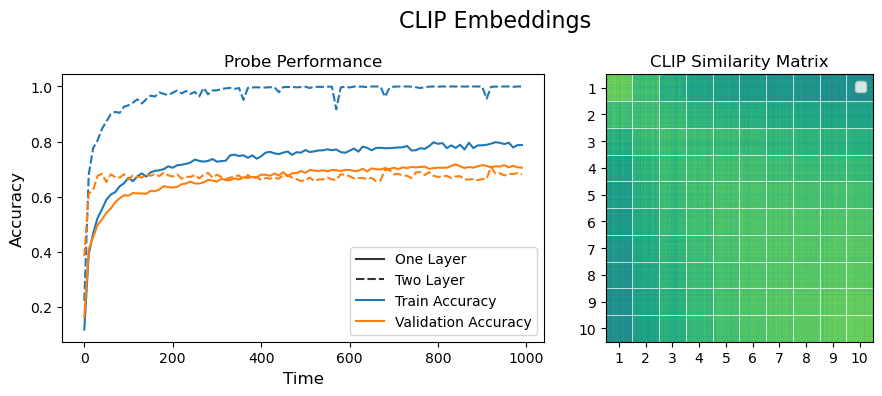

In [7]:
# Plot performance over time.
train_accs = np.array([one_layer_train_accs + two_layer_train_accs]).squeeze()
val_accs = np.array([one_layer_val_accs + two_layer_val_accs]).squeeze()
condition = ['One Layer']*len(one_layer_train_accs) + ['Two Layer']*len(two_layer_train_accs)
time = np.concatenate([np.arange(len(two_layer_train_accs)), np.arange(len(two_layer_train_accs))])
fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)
performance_df = pd.DataFrame({'Train Accuracy': train_accs[::10], 'Val Accuracy': val_accs[::10], 'Condition': condition[::10], 'Time': time[::10]})
sns.lineplot(data=performance_df, x='Time', y='Train Accuracy', style='Condition', ax=axes[0], label='Train Accuracy')
sns.lineplot(data=performance_df, x='Time', y='Val Accuracy', style='Condition', ax=axes[0], label='Validation Accuracy')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_title('Probe Performance', fontsize=12)
# remove the last two legend entries
legend_inds = [2, 3, 0, 4]
handles, labels = axes[0].get_legend_handles_labels()
handles = [handles[i] for i in legend_inds]
labels = [labels[i] for i in legend_inds]
axes[0].legend(handles=handles, labels=labels)
plt.legend()

# Plot the similarity structure of the embeddings.
xs, ys = full_dataset.tensors
sort_idx = ys.argmax(1).argsort()
xs = xs[sort_idx].cpu().numpy()
sim_mat = cosine_similarity(xs, xs)
axes[1].imshow(sim_mat)
axes[1].set_title('CLIP Similarity Matrix', fontsize=12)
# Add some markers for numerosity boundaries
max_numerosity = ys.argmax(1).max() + 1
pos = np.arange(max_numerosity)*task.n_trials + task.n_trials//2
tick_labels = np.arange(max_numerosity) + 1
axes[1].set_xticks(pos, tick_labels)
axes[1].set_yticks(pos, tick_labels)
# Add gridlines
for i in range(max_numerosity):
    axes[1].axvline(i*task.n_trials, color='white', linewidth=0.5)
    axes[1].axhline(i*task.n_trials, color='white', linewidth=0.5)
plt.suptitle('CLIP Embeddings', fontsize=16)

#### Probing DINOv2 (without pooling -- just average token embeddings).

In [8]:
# Compute the average DINOvs embeddings
def compute_avg_embeddings(model, processor, dataloader, device):
    embeddings, targets = [], []
    model.eval()
    with torch.no_grad():
        for xs, ys in tqdm(dataloader, desc='Computing embeddings'):
            xs = xs.to(device)
            inputs = processor(images=xs, return_tensors='pt', do_rescale=False).to(device)
            img_emb = model(**inputs).last_hidden_state
            embeddings.append(img_emb.mean(1))
            targets.append(ys)
    return torch.cat(embeddings), torch.cat(targets)

In [9]:
# Load DINOv2 model and processor
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)

# Compute embeddings
embeddings, targets = compute_avg_embeddings(model, processor, dataloader, device)

# Create a new dataset with embeddings and targets
full_dataset = TensorDataset(embeddings, targets)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize and train the probe
input_dim = embeddings.shape[1]
hidden_dim = input_dim
output_dim = len(torch.unique(targets.argmax(1)))
probe = SimpleMLP(input_dim, hidden_dim, output_dim)
trained_probe, train_accs, val_accs = train_probe(probe, train_loader, val_loader, n_epochs=1000, device=device)

# Evaluate on test set
test_acc = evaluate_probe(trained_probe, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')

Computing embeddings: 100%|██████████| 10/10 [00:47<00:00,  4.80s/it]


Epoch 0/1000 - Train Loss: 2.3014, Train Acc: 0.1433, Val Acc: 0.2293
Epoch 100/1000 - Train Loss: 0.8780, Train Acc: 0.6683, Val Acc: 0.5600
Epoch 200/1000 - Train Loss: 0.7263, Train Acc: 0.7227, Val Acc: 0.6027
Epoch 300/1000 - Train Loss: 0.6513, Train Acc: 0.7462, Val Acc: 0.6347
Epoch 400/1000 - Train Loss: 0.6019, Train Acc: 0.7580, Val Acc: 0.6547
Epoch 500/1000 - Train Loss: 0.5558, Train Acc: 0.7773, Val Acc: 0.6693
Epoch 600/1000 - Train Loss: 0.5217, Train Acc: 0.7948, Val Acc: 0.6840
Epoch 700/1000 - Train Loss: 0.5200, Train Acc: 0.7829, Val Acc: 0.7027
Epoch 800/1000 - Train Loss: 0.5059, Train Acc: 0.7931, Val Acc: 0.7000
Epoch 900/1000 - Train Loss: 0.4729, Train Acc: 0.8077, Val Acc: 0.7120
Test Accuracy: 0.7067


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'DINOv2 Embeddings')

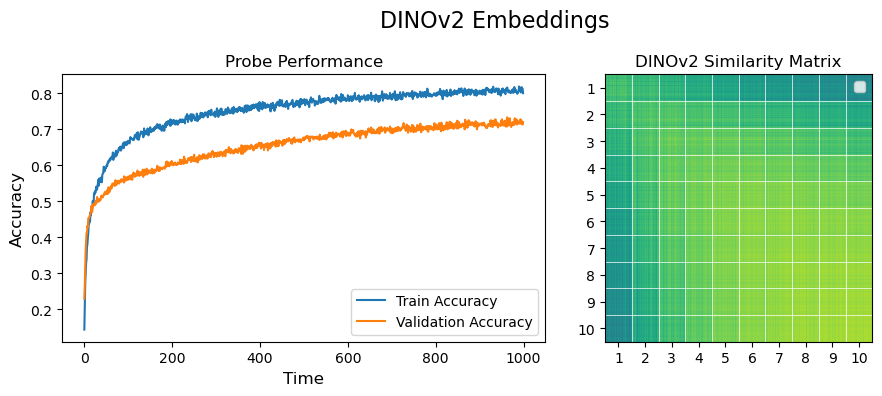

In [10]:
# Plot performance over time.
fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)
performance_df = pd.DataFrame({'Train Accuracy': np.array(train_accs), 'Val Accuracy': np.array(val_accs)})
performance_df['Time'] = np.arange(len(val_accs))
sns.lineplot(data=performance_df, x='Time', y='Train Accuracy', ax=axes[0], label='Train Accuracy')
sns.lineplot(data=performance_df, x='Time', y='Val Accuracy', ax=axes[0], label='Validation Accuracy')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_title('Probe Performance', fontsize=12)
plt.legend()

# Plot the similarity structure of the embeddings.
xs, ys = full_dataset.tensors
sort_idx = ys.argmax(1).argsort()
xs = xs[sort_idx].cpu().numpy()
sim_mat = cosine_similarity(xs, xs)
axes[1].imshow(sim_mat)
axes[1].set_title('DINOv2 Similarity Matrix', fontsize=12)
# Add some markers for numerosity boundaries
max_numerosity = ys.argmax(1).max() + 1
pos = np.arange(max_numerosity)*task.n_trials + task.n_trials//2
tick_labels = np.arange(max_numerosity) + 1
axes[1].set_xticks(pos, tick_labels)
axes[1].set_yticks(pos, tick_labels)
# Add gridlines
for i in range(max_numerosity):
    axes[1].axvline(i*task.n_trials, color='white', linewidth=0.5)
    axes[1].axhline(i*task.n_trials, color='white', linewidth=0.5)
plt.suptitle('DINOv2 Embeddings', fontsize=16)

#### Probing DINOv2 (WITH pooling...).

In [11]:
# Re-define compute embeddings for dinov2, but retain ALL embeddings for analysis.
def compute_all_embeddings(model, processor, dataloader, device):
    embeddings, targets = [], []
    model.eval()
    with torch.no_grad():
        for xs, ys in tqdm(dataloader, desc='Computing embeddings'):
            xs = xs.to(device)
            inputs = processor(images=xs, return_tensors='pt', do_rescale=False).to(device)
            img_emb = model(**inputs).last_hidden_state
            embeddings.append(img_emb)
            targets.append(ys)
    return torch.cat(embeddings), torch.cat(targets)

In [12]:
# Compute embeddings
embeddings, targets = compute_all_embeddings(model, processor, dataloader, device)

# Create a new dataset with embeddings and targets
full_dataset = TensorDataset(embeddings, targets)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize and train the probe
input_dim = embeddings.shape[-1]
hidden_dim = input_dim
output_dim = len(torch.unique(targets.argmax(1)))
pooler = AttentionPooler(input_dim, input_dim)
mlp = SimpleMLP(input_dim, hidden_dim, output_dim)
probe = Probe(pooler, mlp)
trained_probe, train_accs, val_accs = train_probe(probe, train_loader, val_loader, n_epochs=100, device=device, log_interval=10, lr=2e-4)

# Evaluate on test set
test_acc = evaluate_probe(trained_probe, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')

Computing embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

Computing embeddings: 100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Epoch 0/100 - Train Loss: 2.1161, Train Acc: 0.2341, Val Acc: 0.3613
Epoch 10/100 - Train Loss: 0.9144, Train Acc: 0.6227, Val Acc: 0.5840
Epoch 20/100 - Train Loss: 0.7323, Train Acc: 0.7232, Val Acc: 0.6627
Epoch 30/100 - Train Loss: 0.6625, Train Acc: 0.7392, Val Acc: 0.6760
Epoch 40/100 - Train Loss: 0.5646, Train Acc: 0.7853, Val Acc: 0.7067
Epoch 50/100 - Train Loss: 0.5032, Train Acc: 0.8166, Val Acc: 0.7120
Epoch 60/100 - Train Loss: 0.4247, Train Acc: 0.8694, Val Acc: 0.7293
Epoch 70/100 - Train Loss: 0.4150, Train Acc: 0.8521, Val Acc: 0.7280
Epoch 80/100 - Train Loss: 0.3636, Train Acc: 0.8826, Val Acc: 0.7373
Epoch 90/100 - Train Loss: 0.3198, Train Acc: 0.9062, Val Acc: 0.7267
Test Accuracy: 0.7067


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pooled embeddings shape: torch.Size([5000, 768])


Text(0.5, 0.98, 'DINOv2 Embeddings')

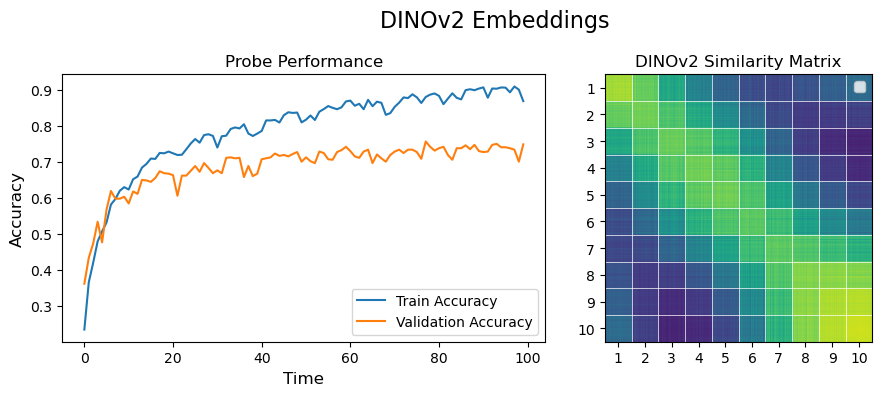

In [13]:
# Plot performance over time.
fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)
performance_df = pd.DataFrame({'Train Accuracy': np.array(train_accs), 'Val Accuracy': np.array(val_accs)})
performance_df['Time'] = np.arange(len(val_accs))
sns.lineplot(data=performance_df, x='Time', y='Train Accuracy', ax=axes[0], label='Train Accuracy')
sns.lineplot(data=performance_df, x='Time', y='Val Accuracy', ax=axes[0], label='Validation Accuracy')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_title('Probe Performance', fontsize=12)
plt.legend()

# Plot the similarity structure of the embeddings.
xs, ys = full_dataset.tensors
_, xs = probe(xs, return_pooled_xs=True)
print(f'Pooled embeddings shape: {xs.shape}')
sort_idx = ys.argmax(1).argsort()
xs = xs[sort_idx].detach().cpu().numpy()
sim_mat = cosine_similarity(xs, xs)
axes[1].imshow(sim_mat)
axes[1].set_title('DINOv2 Similarity Matrix', fontsize=12)
# Add some markers for numerosity boundaries
max_numerosity = ys.argmax(1).max() + 1
pos = np.arange(max_numerosity)*task.n_trials + task.n_trials//2
tick_labels = np.arange(max_numerosity) + 1
axes[1].set_xticks(pos, tick_labels)
axes[1].set_yticks(pos, tick_labels)
# Add gridlines
for i in range(max_numerosity):
    axes[1].axvline(i*task.n_trials, color='white', linewidth=0.5)
    axes[1].axhline(i*task.n_trials, color='white', linewidth=0.5)
plt.suptitle('DINOv2 Embeddings', fontsize=16)

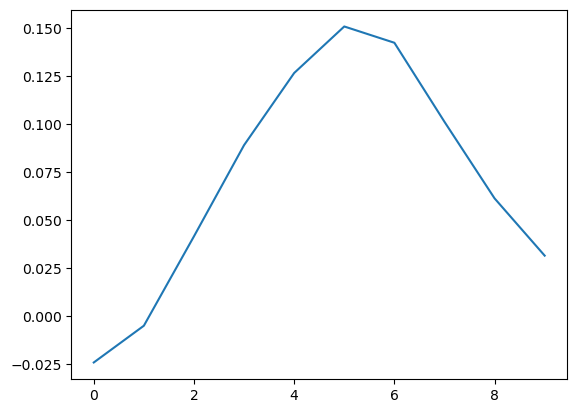

In [14]:
plt.plot(sim_mat.reshape(10, 500, 5000).mean((1,2)))

### Project ideas:
##### 1. Do VLMs have a shape or color bias? (the result may surprise you!)
##### 2. Signatures of compositional feature representations in CLIP? (i.e. replicate and extend [Lewis et al 2022](https://arxiv.org/abs/2212.10537) using TPR probes).